## Contributors: 
Neal Friesenhahn

### Importing Libraries:

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import math
import numpy as np
from sklearn.metrics import classification_report

from amb_sdk.sdk import DarwinSdk

### Configure Darwin:

In [33]:
# Login
ds = DarwinSdk()
file = open("login.txt", "r")
username = file.readline(0)
password = file.readline(1)
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('username', 'password')
if not status:
    print(msg)
    

#### Data Path
Make sure to set this to your local machine's path to the data.

In [3]:
path = './'

### Importing Data:
Data used in this project:
https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu

In [31]:
dataFile = "./Issued_Construction_Permits.csv"
filename= "test10.csv"
test_data = 'testSet10.csv'
data = pd.read_csv(dataFile, skipinitialspace=True)

#Columns with detected mixed types
mixedData_col = [52,54,56,58,59,60,61,62,63,64,65,66]

columnsNames = data.columns.values
#excess labels included in feature drop
#Darwin doesn't like mulitple date fields either so they must be dropped as well
featureDrop = ['Permit Type Desc', 'Permit Num', 'Permit Class', 'Contractor Trade', 'Applied Date', 
               'Issued Date', 'Status Date', 'Expires Date', 'Completed Date', 'Plumbing Valuation', 'Plumbing Valuation Remodel',
               'Electrical Valuation', 'Electrical Valuation Remodel', 'Mechanical Valuation', 'Mechanical Valuation Remodel',
               'MedGas Valuation', 'MedGas Valuation Remodel']
#add mixed datatype col to feature drop until later date of processing 
print("Removed columns from dataset:")
for col in mixedData_col:
    print(columnsNames[col])
    featureDrop.append(columnsNames[col])
    
fullData = data.drop(featureDrop, axis=1)
#data added chronologically to dataset, for now reduce by half for random sampling
testSet = fullData.head(100000)
testSet.to_csv(os.path.join(path, test_data))
reduceSize = math.floor(len(fullData)/2)
reduceData = fullData.tail(reduceSize)
reduceData.to_csv(os.path.join(path, filename))
reduceData.head()

C:\Users\Neal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (52,54,56,58,59,60,61,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Removed columns from dataset:
Contractor Company Name
Contractor Phone
Contractor Address 2
Contractor Zip
Applicant Full Name
Applicant Organization
Applicant Phone
Applicant Address 1
Applicant Address 2
Applicant City
Applicant Zip
Certificate Of Occupancy


,Permit Type,Permit Class Mapped,Work Class,Condominium,Project Name,Description,TCAD ID,Property Legal Description,Day Issued,Calendar Year Issued,...,Link,Project ID,Master Permit Num,Latitude,Longitude,Location,Contractor Full Name,Contractor Address 1,Contractor City,Total Lot SQFT
949267,MP,Residential,New,No,12509 Mexicana Cv,New Sf Residence W Attached Garage Cov'D Porch...,0330400231,LOT 23 BLK B LOS CIELOS SEC 1,THURSDAY,2005,...,https://abc.austintexas.gov/web/permit/public-...,3412250,716347.0,30.169626,-97.627192,"(30.16962574, -97.62719172)",NaN,NaN,Austin,NaN
949268,MP,Residential,New,No,1921 Bird Call Pass,New 1 Sty Sf Residence WAtt Garage Cvd PorchPatio,0245300804,LOT 9 BLK P PIONEER CROSSING WEST SEC 6,WEDNESDAY,2005,...,https://abc.austintexas.gov/web/permit/public-...,3412251,716348.0,30.371681,-97.652043,"(30.37168068, -97.65204275)",NaN,"6500 RIVER PLACE BLVD BLDG 2, #300",AUSTIN,NaN
949269,MP,Residential,New,No,12845 Buenos Aires Pkwy,New Sf Residence W Attached Garage Cov'D Porch...,0330431208,LOT 12 BLK P LOS CIELOS SEC 1,FRIDAY,2005,...,https://abc.austintexas.gov/web/permit/public-...,3412253,716349.0,30.167240,-97.622324,"(30.16723992, -97.62232383)",NaN,NaN,Austin,NaN
949270,MP,Residential,New,No,12608 Campana Dr,New Sf Residence W Attached Garage Cov'D Porch...,0330400215,LOT 39 BLK B LOS CIELOS SEC 1,MONDAY,2005,...,https://abc.austintexas.gov/web/permit/public-...,3412254,716350.0,30.168743,-97.626033,"(30.16874311, -97.62603259)",NaN,NaN,Austin,NaN
949271,MP,Residential,New,No,1105 Mooreland Dr,New Sf Residence W Attached Garage Cov'D Porch...,0438231011,LOT 6 BLK D CHAPPELL HILL,WEDNESDAY,2005,...,https://abc.austintexas.gov/web/permit/public-...,3412255,716351.0,30.150324,-97.828910,"(30.15032383, -97.82891041)",NaN,5716 W US 290 HWY SUITE 205,Austin,NaN


In this dataset we will attempt to use the Permit Type as the class label for the data and because of that we need to remove some columns that also act as labels in that capacity that might skew the results. Columns that are similar to Permit type are:

    Permit Type Description
    Permit Num (since it contain the type in the code)
    Permit Class (functions much like a label)
    Contractor Trade (plummers typically take plumbing jobs, electricians take electrician jobs thus could act as a label)

Tangental Job indicators: (subject to testing and feature engineering)

    *Plumbing Valuation
    *Plumbing Valuation Remodel
    *Electrical Valuation
    *Electrical Valuation Remodel
    *Mechanical Valuation
    *Mechanical Valuation Remodel 
    *MedGas Valuation
    *MedGas Valuation Remodel

It might be interesting to note that a renovation job might include plumbing costs and the difference being the cost threshold which decides if its specifically a plumbing job.

Interesting sidenote our data qualifies as big data under Darwin's algorithms (>500MB in size) as such not only can we sample
at most half our dataset but also the need to remove addional columns before uploading including those above.

### Upload to Darwin

In [6]:
status, dataset = ds.upload_dataset(os.path.join(path, filename))
if not status:
    print(dataset)

#### Clean dataset

In [8]:
# clean dataset
target = "Permit Type"
index = "Applied Date"
status, job_id = ds.clean_data(filename, target = target)
print(job_id)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'job_name': 'b9dcc1ae03fe4d579819e0af124f29d6', 'artifact_name': 'b8b404880ac94b2a8b7f65eddb707f34'}
{'status': 'Requested', 'starttime': '2019-04-18T14:52:05.176978', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test10.csv'], 'artifact_names': ['b8b404880ac94b2a8b7f65eddb707f34'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-18T14:52:05.176978', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test10.csv'], 'artifact_names': ['b8b404880ac94b2a8b7f65eddb707f34'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T14:52:05.176978', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test10.csv'], 'artifact_names': ['b8b404880ac94b2a8b7f65eddb707f34'], 'model_name': None, 'job_error': ''}
{'status'

{'status': 'Running', 'starttime': '2019-04-18T14:52:05.176978', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test10.csv'], 'artifact_names': ['b8b404880ac94b2a8b7f65eddb707f34'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T14:52:05.176978', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test10.csv'], 'artifact_names': ['b8b404880ac94b2a8b7f65eddb707f34'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T14:52:05.176978', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test10.csv'], 'artifact_names': ['b8b404880ac94b2a8b7f65eddb707f34'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T14:52:05.176978', 'endtime': None, 'percent_complete': 0, 'job_type'

### Create and Train Model

In [10]:
model = target + "_model10"
status, job_id = ds.create_model(dataset_names = filename, \
                                 model_name =  model, \
                                 max_train_time = '00:15')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['test10.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model10', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['test10.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['test10.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_na

{'status': 'Running', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': None, 'percent_complete': 12, 'job_type': 'TrainModel', 'loss': 1.0166438817977905, 'generations': 0, 'dataset_names': ['test10.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': None, 'percent_complete': 12, 'job_type': 'TrainModel', 'loss': 1.0166438817977905, 'generations': 0, 'dataset_names': ['test10.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': None, 'percent_complete': 12, 'job_type': 'TrainModel', 'loss': 1.0166438817977905, 'generations': 0, 'dataset_names': ['test10.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': None, 'percent_complete': 12, 'job_type': 'TrainModel', '

#### Check status of job

In [18]:
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Complete', 'starttime': '2019-04-18T15:04:11.147714', 'endtime': '2019-04-18T15:45:03.15463', 'percent_complete': 100, 'job_type': 'TrainModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': ['test10.csv'], 'artifact_names': None, 'model_name': 'Permit Type_model10', 'job_error': ''}


### Analyze Model

In [19]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])


{'status': 'Running', 'starttime': '2019-04-18T15:45:55.72561', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': None, 'artifact_names': ['7b74b3f942384b5780d160330bd68a9d'], 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:45:55.72561', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': None, 'artifact_names': ['7b74b3f942384b5780d160330bd68a9d'], 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:45:55.72561', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': None, 'artifact_names': ['7b74b3f942384b5780d160330bd68a9d'], 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:45:55.72561', 'en

Display most important features of the model.

In [20]:
feature_importance[:10]

Unnamed: 0              0.436638
Project ID              0.363988
Master Permit Num       0.061997
Housing Units           0.029400
Number Of Floors        0.018045
Total Job Valuation     0.010938
Work Class = Remodel    0.010276
Fiscal Year Issued      0.008843
Calendar Year Issued    0.007646
Work Class = New        0.007506
dtype: float64

### Predictions

#### Perform model prediction on the training dataset.

In [21]:
status, artifact = ds.run_model(filename, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-18T15:50:36.998456', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': ['test10.csv'], 'artifact_names': ['9dd299c3071b4ce5bc66f7629718390b'], 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:50:36.998456', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': ['test10.csv'], 'artifact_names': ['9dd299c3071b4ce5bc66f7629718390b'], 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T15:50:36.998456', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': ['test10.csv'], 'artifact_names': ['9dd299c3071b4ce5bc66f7629718390b'], 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18

(True, 'Job completed')

Download predictions from Darwin.

In [22]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,Permit Type,prob_BP,prob_DS,prob_EP,prob_MP,prob_PP
0,MP,3.590347e-28,0.0,0.0,1.0,1.470000e-08
1,MP,1.655939e-29,0.0,0.0,1.0,4.000000e-10
2,MP,7.587439e-28,0.0,0.0,1.0,1.540000e-08
3,MP,8.789642e-27,0.0,0.0,1.0,7.360000e-08
4,MP,1.698114e-30,0.0,0.0,1.0,4.000000e-10


#### Download predictions

In [23]:
prediction.to_csv(os.path.join(path, "prediction10.csv"))

Create visualizations for comparing predictions with actual target. 

              precision    recall  f1-score   support

          BP       1.00      1.00      1.00    248227
          DS       1.00      1.00      1.00     71718
          EP       1.00      1.00      1.00    347547
          MP       1.00      1.00      1.00     40701
          PP       1.00      1.00      1.00    241074

   micro avg       1.00      1.00      1.00    949267
   macro avg       1.00      1.00      1.00    949267
weighted avg       1.00      1.00      1.00    949267



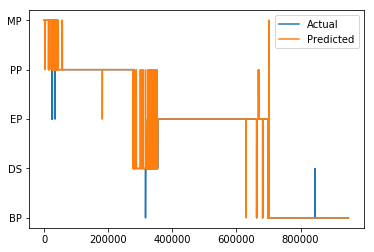

In [24]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(reduceData[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(reduceData[target], prediction[target]))

#### Perform model prediction on test dataset from holdout method.
Upload test data.

In [35]:

status, dataset = ds.upload_dataset(os.path.join(path, test_data))
if not status:
    print(dataset)

400: BAD REQUEST - {"message": "Dataset already exists"}



Clean test data. 

In [36]:
status, job_id = ds.clean_data(test_data, target = target, model_name = model)
print("Model:\n",model)
print("Target: \n",target)
print(job_id)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

Model:
 Permit Type_model10
Target: 
 Permit Type
{'job_name': '4b407a2d52474caabc8234b5953077d7', 'artifact_name': '4de605b0816e410ab1ff68f36c33c5d2'}
{'status': 'Requested', 'starttime': '2019-04-18T16:24:10.60111', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['testSet10.csv'], 'artifact_names': ['4de605b0816e410ab1ff68f36c33c5d2'], 'model_name': None, 'job_error': None}
{'status': 'Failed', 'starttime': '2019-04-18T16:24:10.60111', 'endtime': '2019-04-18T16:24:19.058919', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['testSet10.csv'], 'artifact_names': ['4de605b0816e410ab1ff68f36c33c5d2'], 'model_name': None, 'job_error': 'DarwinInternalErroruncaught'}


Run model on test dataset. 

In [37]:
status, artifact = ds.run_model(test_data, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-18T16:24:38.668054', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': ['testSet10.csv'], 'artifact_names': ['7d8c21ef87ea492cbd616ab6242a0bff'], 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-18T16:24:38.668054', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': ['testSet10.csv'], 'artifact_names': ['7d8c21ef87ea492cbd616ab6242a0bff'], 'model_name': 'Permit Type_model10', 'job_error': ''}
{'status': 'Failed', 'starttime': '2019-04-18T16:24:38.668054', 'endtime': '2019-04-18T16:24:59.51112', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.9059557914733887, 'generations': 1, 'dataset_names': ['testSet10.csv'], 'artifact_names': ['7d8c21ef87ea492cbd616ab6242a0bff'], 'model_name': 'Permit Type_model10', 'job_error': 'FailedDownload: 

(False,
 {'status': 'Failed',
  'starttime': '2019-04-18T16:24:38.668054',
  'endtime': '2019-04-18T16:24:59.51112',
  'percent_complete': 100,
  'job_type': 'RunModel',
  'loss': 0.9059557914733887,
  'generations': 1,
  'dataset_names': ['testSet10.csv'],
  'artifact_names': ['7d8c21ef87ea492cbd616ab6242a0bff'],
  'model_name': 'Permit Type_model10',
  'job_error': 'FailedDownload: Failed to download entity of type Object from location artifacts/c5e7932c-5ca0-11e9-a3a0-5b4cadcb3bcf_4de605b0816e410ab1ff68f36c33c5d2/data.csv'})

Create visualizations for comparing predictions with actual target.

In [ ]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv(os.path.join(path,test_data))
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

### Darwin' Pick for machine learning model

In [29]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'XGBClassifier', 'parameters': {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.26011845115343407, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 290, 'n_jobs': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9077453910198585}}


## Clean up

In [ ]:
ds.delete_all_datasets()
ds.delete_all_models()
ds.delete_all_artifacts()